In [2]:
import os
import time
import random
import pickle
import numpy as np
from copy import deepcopy
from contextlib import nullcontext
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
from cycler import cycler; plt.rcParams["axes.prop_cycle"] = cycler(color=["#000000", "#2180FE", "#EB4275"])
from IPython.display import clear_output

import torch
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'device: {device}')
print(f'os.cpu_count(): {os.cpu_count()}')
!nvidia-smi -L

device: cuda
os.cpu_count(): 20
GPU 0: NVIDIA GeForce RTX 4070 SUPER (UUID: GPU-b10c6cac-b9b4-49fa-2e4d-8ba5c4c711ba)


In [3]:
from cube import Cube
env = Cube()

In [4]:
from model import Model
model = Model()
model.to(device)

Model(
  (embedding): LinearBlock(
    (fc): Linear(in_features=324, out_features=5000, bias=True)
    (relu): ReLU()
    (bn): BatchNorm1d(5000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear_layers): ModuleList(
    (0): LinearBlock(
      (fc): Linear(in_features=5000, out_features=1000, bias=True)
      (relu): ReLU()
      (bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (residual_blocks): ModuleList(
    (0-3): 4 x ResidualBlock(
      (layers): ModuleList(
        (0-1): 2 x LinearBlock(
          (fc): Linear(in_features=1000, out_features=1000, bias=True)
          (relu): ReLU()
          (bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
  )
  (output): Linear(in_features=1000, out_features=12, bias=True)
)

In [5]:
from config import TrainConfig


class ScrambleGenerator(torch.utils.data.Dataset):
    def __init__(
        self,
        num_workers=os.cpu_count(),
        max_depth=TrainConfig.max_depth,
        total_samples=TrainConfig.num_steps*TrainConfig.batch_size_per_depth
    ):
        self.num_workers = num_workers
        self.max_depth = max_depth
        # self.envs = [Cube() for _ in range(num_workers)]
        # self.generators = [env.scrambler(self.max_depth) for env in self.envs]

        self.total_samples = total_samples

    def __len__(self):
        return self.total_samples

    def __getitem__(self, i):
        ''' generate one scramble, consisting of `self.max_depth` data points '''
        # worker_idx = i % self.num_workers
        try:
            X = np.zeros((self.max_depth, 54), dtype=np.int64)
            y = np.zeros((self.max_depth,), dtype=np.int64)
            generator = Cube().scrambler(self.max_depth)
            for j in range(self.max_depth):
                state, last_move = next(generator)
                X[j, :] = state
                y[j] = last_move
            return X, y
        except Exception as e:
            print(f'error: {e}')
            return self.__getitem__(i)


dataloader = torch.utils.data.DataLoader(
    ScrambleGenerator(),
    num_workers=0,
    batch_size=TrainConfig.batch_size_per_depth
)

# Get one batch from the dataloader
sample_batch = next(iter(dataloader))

# Unpack X and y from the batch
X, y = sample_batch

# Check shapes and data types
print("X shape:", X.shape)  # Expected: (batch_size, max_depth, 54)
print("y shape:", y.shape)  # Expected: (batch_size, max_depth)
print("X dtype:", X.dtype)
print("y dtype:", y.dtype)

# Optional: Print the first few entries to inspect contents
print("Sample X:", X[0])  # Print the first sample in X
print("Sample y:", y[0])  # Print the first sample in y
print("Sample y:", y[1])  # Print the first sample in y


X shape: torch.Size([1000, 26, 54])
y shape: torch.Size([1000, 26])
X dtype: torch.int64
y dtype: torch.int64
Sample X: tensor([[2, 0, 0,  ..., 5, 5, 5],
        [2, 2, 2,  ..., 5, 5, 3],
        [2, 2, 2,  ..., 1, 5, 3],
        ...,
        [1, 4, 2,  ..., 3, 2, 2],
        [5, 4, 2,  ..., 2, 3, 3],
        [5, 4, 2,  ..., 1, 3, 3]])
Sample y: tensor([ 4,  0,  1, 11,  3,  8,  4,  6,  1, 11,  7, 11, 11,  3,  2,  5,  1,  8,
         0, 10,  9,  7,  8,  5, 10,  1])
Sample y: tensor([11,  7, 10,  3,  7,  3,  6,  1,  5,  0,  9, 10,  9,  8, 10,  0,  9,  9,
         2,  1,  2,  7,  4,  4,  5,  0])


In [6]:
def plot_loss_curve(h):
    fig, ax = plt.subplots(1, 1)
    ax.plot(h)
    ax.set_xlabel("Steps")
    ax.set_ylabel("Cross-entropy loss")
    ax.set_xscale("log")
    plt.show()


def train(model, dataloader):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=TrainConfig.learning_rate)
    g = iter(dataloader)
    h = []
    ctx = torch.cuda.amp.autocast(
        dtype=torch.float16) if TrainConfig.ENABLE_FP16 else nullcontext()

    for i in trange(1, TrainConfig.num_steps + 1):
        batch_x, batch_y = next(g)
        batch_x, batch_y = batch_x.reshape(-1,
                                           54).to(device), batch_y.reshape(-1).to(device)

        with ctx:
            pred_y = model(batch_x)
            loss = loss_fn(pred_y, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        h.append(loss.item())
        if TrainConfig.INTERVAL_PLOT and i % TrainConfig.INTERVAL_PLOT == 0:
            clear_output()
            plot_loss_curve(h)
        if TrainConfig.INTERVAL_SAVE and i % TrainConfig.INTERVAL_SAVE == 0:
            torch.save(model.state_dict(), f"{i}steps.pth")
            print("Model saved.")
    print(
        f"Trained on data equivalent to {TrainConfig.batch_size_per_depth * TrainConfig.num_steps} solves.")
    return model


train_here = False
if train_here:
    model = train(model, dataloader)
else:
    print('training is disabled')
    model.load_state_dict(torch.load('10000steps.pth'))

training is disabled


C:\Users\Scarlet1ssimo\AppData\Local\Temp\ipykernel_50784\515275775.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('10000steps.pth'))


In [7]:
# Validate Accuracy
def validate(model, num_samples=100):
    model.eval()
    correct = 0
    cnt = 0
    with torch.no_grad():
        for _ in range(num_samples):
            env = Cube()
            generator = env.scrambler(TrainConfig.max_depth)
            sub_correct = 0
            sub_cnt = 0
            for i in range(TrainConfig.max_depth):
                state, move = next(generator)
                pred = model(torch.tensor(state, dtype=torch.int64).to(
                    device)).argmax().item()
                if pred == move:
                    sub_correct += 1
                sub_cnt+=1
            correct += sub_correct
            cnt += sub_cnt
            print(f"Accuracy for subtask: {sub_correct} / {sub_cnt} = {sub_correct/sub_cnt:.2%}. Total accuracy: {correct / cnt:.2%}")
    return correct / cnt


validate(model)

Accuracy for subtask: 11 / 26 = 42.31%. Total accuracy: 42.31%
Accuracy for subtask: 11 / 26 = 42.31%. Total accuracy: 42.31%
Accuracy for subtask: 15 / 26 = 57.69%. Total accuracy: 47.44%
Accuracy for subtask: 15 / 26 = 57.69%. Total accuracy: 50.00%
Accuracy for subtask: 12 / 26 = 46.15%. Total accuracy: 49.23%
Accuracy for subtask: 10 / 26 = 38.46%. Total accuracy: 47.44%
Accuracy for subtask: 11 / 26 = 42.31%. Total accuracy: 46.70%
Accuracy for subtask: 12 / 26 = 46.15%. Total accuracy: 46.63%
Accuracy for subtask: 13 / 26 = 50.00%. Total accuracy: 47.01%
Accuracy for subtask: 11 / 26 = 42.31%. Total accuracy: 46.54%
Accuracy for subtask: 14 / 26 = 53.85%. Total accuracy: 47.20%
Accuracy for subtask: 11 / 26 = 42.31%. Total accuracy: 46.79%
Accuracy for subtask: 13 / 26 = 50.00%. Total accuracy: 47.04%
Accuracy for subtask: 15 / 26 = 57.69%. Total accuracy: 47.80%
Accuracy for subtask: 11 / 26 = 42.31%. Total accuracy: 47.44%
Accuracy for subtask: 14 / 26 = 53.85%. Total accuracy:

0.4907692307692308

In [8]:
if "DeepCubeA"!=os.getcwd().split("/")[-1]:
    if not os.path.exists('DeepCubeA'):
        !git clone -q https://github.com/forestagostinelli/DeepCubeA
    %cd ./DeepCubeA/

print('### Optimal Solver ###')
filename = 'data/cube3/test/data_0.pkl'
with open(filename, 'rb') as f:
    result_Optimal = pickle.load(f)

    print(result_Optimal.keys())
    result_Optimal["solution_lengths"] = [len(s) for s in result_Optimal["solutions"]]
    result_Optimal["solution_lengths_count"] = {
        i: result_Optimal["solution_lengths"].count(i)
        for i in range(min(result_Optimal["solution_lengths"]), max(result_Optimal["solution_lengths"]))
    }

    print('No. of cases:', len(result_Optimal["solution_lengths"]))

print('\n### DeepCubeA ###')
filename = 'results/cube3/results.pkl'
with open(filename, 'rb') as f:
    result_DeepCubeA = pickle.load(f)

    print(result_DeepCubeA.keys())
    result_DeepCubeA["solution_lengths"] = [len(s) for s in result_DeepCubeA["solutions"]]
    result_DeepCubeA["solution_lengths_count"] = {
        i: result_DeepCubeA["solution_lengths"].count(i)
        for i in range(min(result_DeepCubeA["solution_lengths"]), max(result_DeepCubeA["solution_lengths"]))
    }

    print('No. of cases:', len(result_DeepCubeA["solution_lengths"]))

%cd ../

c:\Users\Scarlet1ssimo\Documents\444\final\DeepCubeA
### Optimal Solver ###
dict_keys(['states', 'times', 'solutions', 'num_nodes_generated'])
No. of cases: 1000

### DeepCubeA ###
dict_keys(['states', 'solutions', 'paths', 'times', 'num_nodes_generated'])
No. of cases: 1000
c:\Users\Scarlet1ssimo\Documents\444\final


C:\Users\Scarlet1ssimo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [9]:
# Convert optimal solutions to test scrambles
def solution2scramble(solution):
    return [m[0] if m[1] == -1 else m[0] + "'" for m in solution[::-1]]

test_scrambles = [solution2scramble(s) for s in result_Optimal["solutions"]]

print(f"""Example:\n{result_Optimal["solutions"][0]}\n-> {test_scrambles[0]}""")

Example:
[['D', -1], ['F', 1], ['R', 1], ['U', -1], ['F', 1], ['F', 1], ['R', 1], ['U', 1], ['F', 1], ['R', 1], ['B', -1], ['R', -1], ['F', -1], ['R', -1], ['D', -1], ['U', -1], ['R', -1], ['U', -1], ['U', -1], ['R', -1], ['U', 1], ['B', -1]]
-> ['B', "U'", 'R', 'U', 'U', 'R', 'U', 'D', 'R', 'F', 'R', 'B', "R'", "F'", "U'", "R'", "F'", "F'", 'U', "R'", "F'", 'D']


In [14]:
from config import SearchConfig
from cube import QTM


@torch.no_grad()
def beam_search(
    env,
    model,
    beam_width=SearchConfig.beam_width,
    max_depth=SearchConfig.max_depth,
    skip_redundant_moves=True,
):
    """
    Best-first search algorithm.
    Input:
        env: A scrambled instance of the given environment.
        model: PyTorch model used to predict the next move(s).
        beam_width: Number of top solutions to return per depth.
        max_depth: Maximum depth of the search tree.
        skip_redundant_moves: If True, skip redundant moves.
    Output:
        if solved successfully:
            True, {'solutions':solution path, "num_nodes_generated":number of nodes expanded, "times":time taken to solve}
        else:
            False, None
    """
    model.eval()
    with torch.cuda.amp.autocast(dtype=torch.float16) if SearchConfig.ENABLE_FP16 else nullcontext():
        # metrics
        num_nodes_generated, time_0 = 0, time.time()
        candidates = [
            {"state": deepcopy(env.state), "path": [], "value": 1.}
        ]  # list of dictionaries

        for depth in range(max_depth+1):
            # TWO things at a time for every candidate: 1. check if solved & 2. add to batch_x
            batch_x = np.zeros(
                (len(candidates), env.state.shape[-1]), dtype=np.int64)
            for i, c in enumerate(candidates):
                c_path, env.state = c["path"], c["state"]
                if c_path:
                    env.move(c_path[-1])
                    num_nodes_generated += 1
                    if env.is_solved():
                        # Revert: array of indices => array of notations
                        c_path = [str(env.mode.NUM2CHAR[i]) for i in c_path]
                        return True, {'solutions': c_path, "num_nodes_generated": num_nodes_generated, "times": time.time()-time_0}
                batch_x[i, :] = env.state

            # after checking the nodes expanded at the deepest
            if depth == max_depth:
                print("Solution not found.")
                return False, None

            # make predictions with the trained DNN
            batch_x = torch.from_numpy(batch_x).to(device)
            batch_p = model(batch_x)
            batch_p = torch.nn.functional.softmax(batch_p, dim=-1)
            batch_p = batch_p.detach().cpu().numpy()

            # loop over candidates
            # storage for the depth-level candidates storing (path, value, index).
            candidates_next_depth = []
            for i, c in enumerate(candidates):
                c_path = c["path"]
                # output logits for the given state
                value_distribution = batch_p[i, :]
                # multiply the cumulative probability so far of the expanded path
                value_distribution *= c["value"]

                # iterate over all possible moves.
                for m, value in enumerate(value_distribution):
                    m = env.mode.getCancel(m)
                    # predicted value to expand the path with the given move.

                    if c_path and skip_redundant_moves:
                        if m not in env.mode.MOVES_NO_CANCEL[c_path[-1]]:
                            # Two mutually canceling moves
                            continue
                        elif len(c_path) > 1:
                            # if c_path[-2] == c_path[-1] == m:
                            if c_path[-2] == c_path[-1] == m:
                                # Three subsequent moves that could be one
                                continue
                            # elif (
                            #     c_path[-2][0] == m[0] and len(c_path[-2] + m) == 3
                            #     and c_path[-1][0] == env.pairing[m[0]]
                            # ):
                            # elif env.mode.isOpposite(c_path[-2], c_path[-1]) and env.mode.isSameFace(j, c_path[-2]):
                                # Two mutually canceling moves sandwiching an opposite face move
                                # continue

                    # add to the next-depth candidates unless 'continue'd.
                    candidates_next_depth.append({
                        'state': deepcopy(c['state']),
                        "path": c_path+[m],
                        "value": value,
                    })

            # sort potential paths by expected values and renew as 'candidates'
            candidates = sorted(candidates_next_depth,
                                key=lambda item: -item['value'])
            # if the number of candidates exceed that of beam width 'beam_width'
            candidates = candidates[:beam_width]

In [15]:
result_ours = {
    "solutions":[],
    "num_nodes_generated":[],
    "times":[]
}
for scramble in tqdm(test_scrambles, position=0):
    # reset and scramble
    env.reset()
    env.apply(scramble)
    # solve
    success, result = beam_search(env, model)
    if success:
        for k in result_ours.keys():
            result_ours[k].append(result[k])
    else:
        result_ours["solutions"].append(None)

result_ours['solution_lengths'] = [len(e) for e in result_ours['solutions'] if e]
result_ours['solution_lengths_count'] = {
    i: result_ours["solution_lengths"].count(i)
    for i in range(min(result_ours["solution_lengths"]), max(result_ours["solution_lengths"]))
}

with open('result_ours.pkl', 'wb') as f:
    pickle.dump(result_ours, f)

f"Successfully solved {len(result_ours['times'])} cases out of {len(result_ours['solutions'])}"

  4%|▍         | 38/1000 [01:22<35:00,  2.18s/it]


KeyboardInterrupt: 

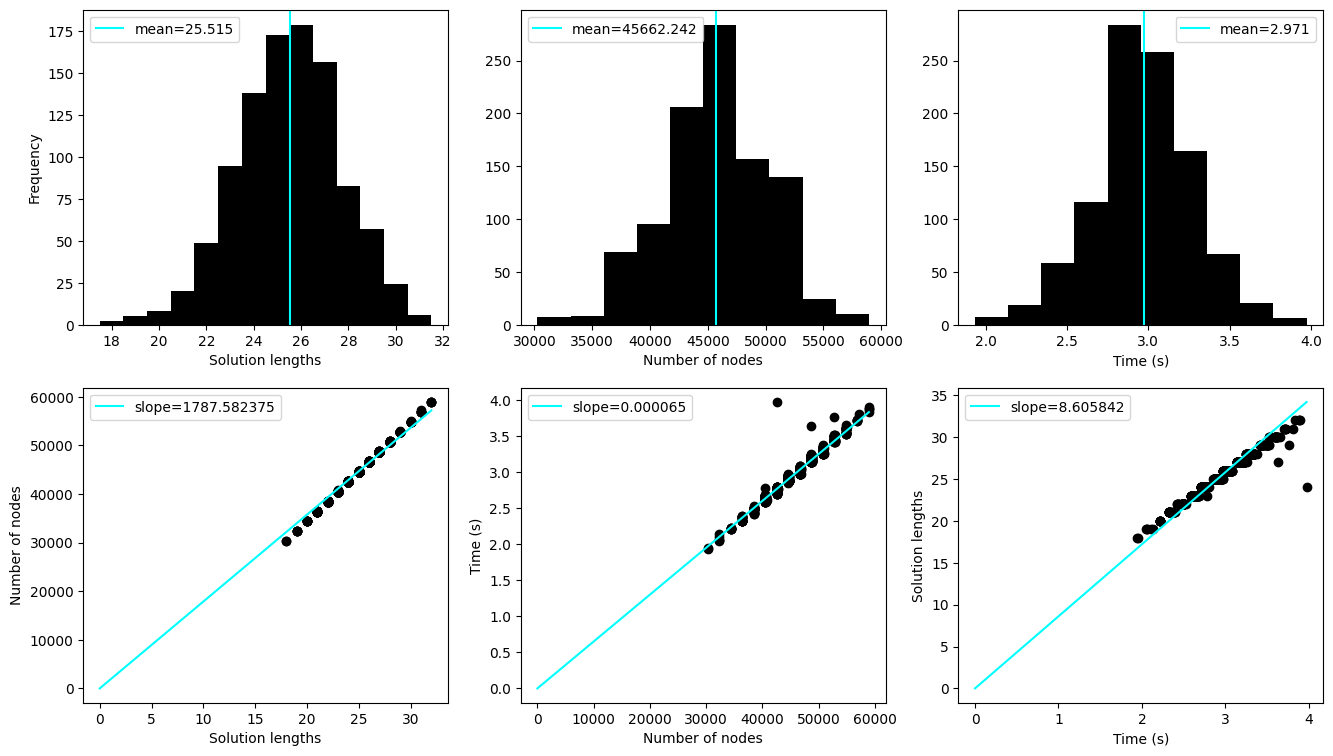

In [4]:
with open('result_ours.pkl', 'rb') as f:
    result_ours = pickle.load(f)

# Visualize result
fig, ax = plt.subplots(2, 3, figsize=(16, 9))
ax = ax.ravel()
ax[0].set_ylabel("Frequency")
ax[1].set_xlabel("Number of nodes")

key_to_text = {
    "solution_lengths":    "Solution lengths",
    'num_nodes_generated': "Number of nodes",
    "times":               "Time (s)",
}

for i, k in enumerate(["solution_lengths", "num_nodes_generated", "times"]):
    v = result_ours[k]
    if k == "solution_lengths":
        v_count = result_ours['solution_lengths_count']
        ax[i].bar(v_count.keys(), v_count.values(), width=1.0)
    else:
        ax[i].hist(v)
    ax[i].axvline(np.mean(v), color="#00ffff", label=f"mean={np.mean(v):.3f}")
    ax[i].set_xlabel(key_to_text[k])
    ax[i].legend()

for i, (key_x, key_y) in enumerate([("solution_lengths", "num_nodes_generated"), ("num_nodes_generated", "times"), ("times", "solution_lengths")]):
    i += 3
    x, y = [result_ours[k] for k in [key_x, key_y]]
    ax[i].set_xlabel(key_to_text[key_x])
    ax[i].set_ylabel(key_to_text[key_y])

    x_range = np.linspace(0, max(x), 100)
    coef = np.mean(np.squeeze(np.array(y) / np.array(x)))
    ax[i].plot(x_range, x_range * coef,
               label=f"slope={coef:.6f}", color="#00ffff")
    ax[i].scatter(x, y)
    ax[i].legend()

plt.show()